# Spatial Analysis of Irrigation Values (1980 - 2015)

.... 

**Outline:**
1. Setup and Configuration
2. Data Ingestion and Preprocessing
3. Pixel Classification (Inside vs. Outside)
4. Descriptive Statistics
5. Distribution Visualization
6. Hypothesis Testing and Effect Sizes
7. Bootstrap Confidence Intervals
8. Summary Figures Over Time
9. Interpretation Aids

In [8]:
import os, sys, warnings
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from rasterio.features import geometry_mask
from libpysal.weights import KNN
from esda.moran import Moran, Moran_Local
from tqdm import tqdm

# Custom Utility Imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from Code.utils.utility import load_config, resolve_path
from Code.utils.spatial_utility import load_raster_and_reproject

warnings.filterwarnings("ignore")
config = load_config()

In [2]:
def load_irrigation_arrays(years, config):
    arrays = {}
    for year in years:
        path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
        with rasterio.open(path) as src:
            arrays[year] = src.read(1)
    return arrays

years = [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]
irrigation_arrays = load_irrigation_arrays(years, config)



In [ ]:
def compute_global_moran(irrigation_arrays, config, years, n_neighbors=8):
    results = []

    for year in tqdm(years):
        print(f"Processing {year}...")

        # --- Load Raster ---
        path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
        with rasterio.open(path) as src:
            irrigation = src.read(1)
            transform = src.transform
            crs = src.crs
            nodata = src.nodata

            # --- Get valid pixel coordinates and values ---
            rows, cols = np.where(~np.isnan(irrigation) & (irrigation != nodata))
            values = irrigation[rows, cols]
            xs, ys = rasterio.transform.xy(transform, rows, cols)
            coords = np.column_stack([xs, ys])
            points = gpd.GeoDataFrame({'value': values}, geometry=gpd.points_from_xy(xs, ys), crs=crs)

        # --- Load vectorized dam command area for the year ---
        ca_path = os.path.join(resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path']), f"merged_CA_{year}.shp")
        ca_year = gpd.read_file(ca_path).to_crs(crs)

        # --- Label points inside or outside CA ---
        points['in_ca'] = points.geometry.within(ca_year.unary_union)

        for group, mask in [('inside', points['in_ca']), ('outside', ~points['in_ca'])]:
            subset = points[mask & (points['value'] > 0)].copy()

            if len(subset) < 50:
                print(f"Skipping {group} {year} (too few points: {len(subset)})")
                continue

            coords_arr = np.array([[pt.x, pt.y] for pt in subset.geometry])
            knn = KNN.from_array(coords_arr, k=n_neighbors)
            moran = Moran(subset['value'].values, knn)

            results.append({
                'Year': year,
                'Group': group,
                'Moran_I': moran.I,
                'p_value': moran.p_norm,
                'n': len(subset)
            })

    return pd.DataFrame(results)

# === Run the Moran analysis ===
df_moran = compute_global_moran(irrigation_arrays, config, years)

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_moran, x='Year', y='Moran_I', hue='Group', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Global Moran's I Over Time (Pixel-level Irrigation Intensity)")
plt.ylabel("Moran's I")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from skgstat import Variogram
import random

def compute_semivariograms(irrigation_arrays, config, years, n_samples=1000):
    results = {}

    for year in tqdm(years):
        print(f"Semivariogram for {year}...")

        # Load array
        array = irrigation_arrays[year]
        path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
        with rasterio.open(path) as src:
            transform = src.transform
            crs = src.crs
            nodata = src.nodata
            rows, cols = np.where(~np.isnan(array) & (array != nodata))
            values = array[rows, cols]
            xs, ys = rasterio.transform.xy(transform, rows, cols)
            gdf = gpd.GeoDataFrame({'value': values}, geometry=gpd.points_from_xy(xs, ys), crs=crs)

        # Load CA polygon
        ca_path = os.path.join(resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path']), f"merged_CA_{year}.shp")
        ca_year = gpd.read_file(ca_path).to_crs(crs)

        gdf['in_ca'] = gdf.geometry.within(ca_year.unary_union)

        results[year] = {}

        for label, subset in [('inside', gdf[gdf['in_ca']]), ('outside', gdf[~gdf['in_ca']])]:
            sample = subset[subset['value'] > 0].copy()
            if len(sample) < n_samples:
                sample = sample
            else:
                sample = sample.sample(n=n_samples, random_state=42)

            coords_arr = np.array([[geom.x, geom.y] for geom in sample.geometry])
            values_arr = sample['value'].values

            V = Variogram(coords_arr, values_arr, n_lags=20, maxlag='auto', normalize=False)
            results[year][label] = V

    return results

variogram_results = compute_semivariograms(irrigation_arrays, config, years, n_samples=1000)



In [ ]:

def plot_semivariograms(variogram_results, years_to_plot):
    for year in years_to_plot:
        plt.figure(figsize=(8, 5))
        for label in ['inside', 'outside']:
            if year in variogram_results and label in variogram_results[year]:
                V = variogram_results[year][label]
                distances = V.bins
                semivars = V.experimental
                plt.plot(distances, semivars, marker='o', label=label)
        plt.title(f"Semivariogram of Irrigation Values ({year})")
        plt.xlabel("Lag Distance (m)")
        plt.ylabel("Semivariance")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_semivariograms(variogram_results, years_to_plot=[1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])


In [ ]:
def plot_semivariograms_by_group_over_time(variogram_results, years, figsize=(14, 6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    for year in years:
        if year not in variogram_results:
            continue

        for idx, group in enumerate(['inside', 'outside']):
            if group not in variogram_results[year]:
                continue

            V = variogram_results[year][group]
            distances = V.bins
            semivars = V.experimental

            axes[idx].plot(distances, semivars, marker='o', label=str(year))

    # Labeling
    axes[0].set_title("Inside Dam Command Areas")
    axes[1].set_title("Outside Dam Command Areas")
    for ax in axes:
        ax.set_xlabel("Lag Distance (m)")
        ax.set_ylabel("Semivariance")
        ax.grid(True)
        ax.legend(title="Year", fontsize=9)
    plt.suptitle("Semivariograms by Year: Inside vs Outside Dam Command Areas", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_semivariograms_by_group_over_time(variogram_results, years)


In [ ]:
def run_lisa_analysis(irrigation_arrays, config, years, n_samples=2000):
    results = {}

    for year in tqdm(years):
        print(f"Running LISA for {year}...")

        # Load irrigation raster and transform
        array = irrigation_arrays[year]
        path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
        with rasterio.open(path) as src:
            transform = src.transform
            crs = src.crs
            nodata = src.nodata
            rows, cols = np.where(~np.isnan(array) & (array != nodata))
            values = array[rows, cols]
            xs, ys = rasterio.transform.xy(transform, rows, cols)
            gdf = gpd.GeoDataFrame({'value': values}, geometry=gpd.points_from_xy(xs, ys), crs=crs)

        # Sample subset
        gdf = gdf[gdf['value'] > 0]
        gdf = gdf.sample(n=min(n_samples, len(gdf)), random_state=42)

        coords = np.array([[geom.x, geom.y] for geom in gdf.geometry])
        w = KNN.from_array(coords, k=8)
        w.transform = 'r'

        lisa = Moran_Local(gdf['value'].values.astype(np.float64), w)

        # Store classification
        gdf['Is_Sig'] = lisa.p_sim < 0.05
        gdf['Quadrant'] = lisa.q
        gdf['LISA_Class'] = 'Not significant'
        gdf.loc[(gdf['Is_Sig']) & (gdf['Quadrant'] == 1), 'LISA_Class'] = 'High-High'
        gdf.loc[(gdf['Is_Sig']) & (gdf['Quadrant'] == 2), 'LISA_Class'] = 'Low-High'
        gdf.loc[(gdf['Is_Sig']) & (gdf['Quadrant'] == 3), 'LISA_Class'] = 'Low-Low'
        gdf.loc[(gdf['Is_Sig']) & (gdf['Quadrant'] == 4), 'LISA_Class'] = 'High-Low'

        results[year] = gdf

    return results

lisa_results = run_lisa_analysis(irrigation_arrays, config, years, n_samples=2000)


In [ ]:
def plot_lisa_clusters(results, year, figsize=(8, 8)):
    gdf = results[year]

    colors = {
        'High-High': '#d7191c',
        'Low-Low': '#2c7bb6',
        'High-Low': '#fdae61',
        'Low-High': '#abd9e9',
        'Not significant': '#d3d3d3'
    }

    fig, ax = plt.subplots(figsize=figsize)
    for label, color in colors.items():
        gdf[gdf['LISA_Class'] == label].plot(ax=ax, markersize=5, color=color, label=label)

    ax.set_title(f"LISA Cluster Map - Irrigation Intensity ({year})")
    ax.axis('off')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

for yr in years:
    plot_lisa_clusters(lisa_results, yr)

In [20]:
import os, sys, warnings
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
from rasterio.features import geometry_mask
from libpysal.weights import KNN
from esda.moran import Moran, Moran_Local
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from scipy import ndimage
from skimage.measure import label, regionprops

# Suppress warnings
warnings.filterwarnings('ignore')

# ====================================================================
# FIXED HELPER FUNCTIONS
# ====================================================================

def debug_crs_and_bounds(gdf, ca_gdf, year):
    """Debug function to check CRS and bounds compatibility"""
    print(f"\n=== DEBUG INFO FOR {year} ===")
    print(f"LISA data CRS: {gdf.crs}")
    print(f"Command Area CRS: {ca_gdf.crs}")
    print(f"LISA bounds: {gdf.total_bounds}")
    print(f"CA bounds: {ca_gdf.total_bounds}")
    print(f"LISA sample points: {gdf.geometry.iloc[:3].tolist()}")
    print(f"CA sample geometry type: {type(ca_gdf.geometry.iloc[0])}")

def ensure_same_crs(gdf1, gdf2, target_crs='EPSG:4326'):
    """Ensure both GeoDataFrames have the same CRS"""
    if gdf1.crs != target_crs:
        gdf1 = gdf1.to_crs(target_crs)
    if gdf2.crs != target_crs:
        gdf2 = gdf2.to_crs(target_crs)
    return gdf1, gdf2

def adaptive_dbscan_params(coords, base_eps_km=5, min_samples=3):
    """
    Adaptively adjust DBSCAN parameters based on data density
    """
    if len(coords) < 10:
        return base_eps_km / 111, max(2, min_samples)
    
    # Calculate average nearest neighbor distance
    from scipy.spatial.distance import cdist
    sample_size = min(100, len(coords))
    sample_coords = coords[np.random.choice(len(coords), sample_size, replace=False)]
    
    distances = cdist(sample_coords, sample_coords)
    np.fill_diagonal(distances, np.inf)
    nn_distances = np.min(distances, axis=1)
    avg_nn_distance = np.mean(nn_distances)
    
    # Adjust epsilon based on data density
    adjusted_eps = max(base_eps_km / 111, avg_nn_distance * 3)
    adjusted_min_samples = max(2, int(len(coords) * 0.01))  # 1% of points
    
    print(f"  Adaptive DBSCAN: eps={adjusted_eps:.4f} deg ({adjusted_eps*111:.1f}km), min_samples={adjusted_min_samples}")
    return adjusted_eps, adjusted_min_samples

# ====================================================================
# FIXED HOTSPOT ANALYSIS FUNCTIONS
# ====================================================================

def identify_hotspot_clusters_fixed(lisa_gdf, eps_km=10, min_samples=3):
    """
    Fixed version of hotspot clustering with better parameter handling
    """
    # Filter to High-High clusters only
    hotspots = lisa_gdf[lisa_gdf['LISA_Class'] == 'High-High'].copy()
    
    if len(hotspots) == 0:
        print(f"  No High-High clusters found")
        return gpd.GeoDataFrame()
    
    print(f"  Found {len(hotspots)} High-High points")
    
    # Extract coordinates
    coords = np.array([[geom.x, geom.y] for geom in hotspots.geometry])
    
    # Use adaptive parameters
    eps_degrees, min_samples_adj = adaptive_dbscan_params(coords, eps_km, min_samples)
    
    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps_degrees, min_samples=min_samples_adj).fit(coords)
    hotspots['cluster_id'] = clustering.labels_
    
    # Remove noise points (cluster_id = -1)
    valid_clusters = hotspots[hotspots['cluster_id'] != -1]
    noise_points = len(hotspots) - len(valid_clusters)
    
    n_clusters = len(valid_clusters['cluster_id'].unique()) if len(valid_clusters) > 0 else 0
    print(f"  DBSCAN found {n_clusters} clusters")
    print(f"  {noise_points} points classified as noise")
    
    return valid_clusters

def calculate_cluster_centroids_fixed(clustered_hotspots):
    """Calculate centroid and metrics for each hotspot cluster"""
    if len(clustered_hotspots) == 0:
        return pd.DataFrame()
        
    cluster_stats = []
    
    for cluster_id in clustered_hotspots['cluster_id'].unique():
        cluster_points = clustered_hotspots[clustered_hotspots['cluster_id'] == cluster_id]
        
        # Calculate centroid
        centroid_x = cluster_points.geometry.x.mean()
        centroid_y = cluster_points.geometry.y.mean()
        
        # Calculate cluster metrics
        stats = {
            'cluster_id': cluster_id,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'n_points': len(cluster_points),
            'total_irrigation': cluster_points['value'].sum(),
            'mean_irrigation': cluster_points['value'].mean(),
            'area_convex_hull': cluster_points.geometry.unary_union.convex_hull.area
        }
        cluster_stats.append(stats)
    
    return pd.DataFrame(cluster_stats)

def track_hotspot_migration_fixed(lisa_results, config, years, eps_km=10, min_samples=3):
    """
    Fixed version with proper CRS handling and debugging
    """
    yearly_clusters = {}
    yearly_centroids = {}
    
    # Process each year
    for year in years:
        print(f"Processing hotspots for {year}...")
        
        # Get LISA data
        gdf = lisa_results[year].copy()
        
        # Load command area and ensure same CRS
        try:
            ca_dir = resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path'])
            ca_path = os.path.join(ca_dir, f"merged_CA_{year}.shp")
            
            if not os.path.exists(ca_path):
                print(f"  Warning: CA file not found: {ca_path}")
                continue
                
            ca_gdf = gpd.read_file(ca_path)
            
            # Ensure same CRS
            gdf, ca_gdf = ensure_same_crs(gdf, ca_gdf)
            
            # Debug information
            debug_crs_and_bounds(gdf, ca_gdf, year)
            
            # Determine inside/outside CA using better spatial join
            gdf['in_ca'] = gdf.geometry.intersects(ca_gdf.unary_union)
            
            # Check results
            n_inside = gdf['in_ca'].sum()
            n_outside = (~gdf['in_ca']).sum()
            print(f"  Spatial join results: {n_inside} inside, {n_outside} outside")
            
            if n_inside == 0:
                print(f"  WARNING: No points found inside command areas for {year}")
                print(f"  This might indicate a CRS or geometry issue")
                
        except Exception as e:
            print(f"  Error loading CA data for {year}: {e}")
            # Continue with all points marked as outside
            gdf['in_ca'] = False
        
        # Identify clusters
        clustered = identify_hotspot_clusters_fixed(gdf, eps_km, min_samples)
        yearly_clusters[year] = clustered
        
        # Calculate centroids
        centroids = calculate_cluster_centroids_fixed(clustered)
        if len(centroids) > 0:
            centroids['year'] = year
            yearly_centroids[year] = centroids
            print(f"  Found {len(centroids)} cluster centroids")
        else:
            print(f"  No centroids calculated")
    
    # Combine all centroids
    if yearly_centroids:
        all_centroids = pd.concat(yearly_centroids.values(), ignore_index=True)
    else:
        all_centroids = pd.DataFrame()
    
    return yearly_clusters, all_centroids

def analyze_hotspot_persistence_fixed(all_centroids, years, distance_threshold_km=15):
    """
    Fixed version with more lenient distance threshold
    """
    if len(all_centroids) == 0:
        print("No centroids available for persistence analysis")
        return pd.DataFrame()
        
    distance_threshold_deg = distance_threshold_km / 111  # Convert to degrees
    
    persistence_analysis = []
    
    for i, base_year in enumerate(years[:-1]):
        next_year = years[i + 1]
        
        base_centroids = all_centroids[all_centroids['year'] == base_year]
        next_centroids = all_centroids[all_centroids['year'] == next_year]
        
        print(f"Comparing {base_year} ({len(base_centroids)} centroids) to {next_year} ({len(next_centroids)} centroids)")
        
        if len(base_centroids) == 0 or len(next_centroids) == 0:
            continue
            
        # Calculate distances between centroids
        base_coords = base_centroids[['centroid_x', 'centroid_y']].values
        next_coords = next_centroids[['centroid_x', 'centroid_y']].values
        
        distances = cdist(base_coords, next_coords)
        
        # Find matches (persistent hotspots)
        matched_base = []
        matched_next = []
        
        for j, base_idx in enumerate(range(len(base_centroids))):
            min_dist_idx = np.argmin(distances[j])
            min_dist = distances[j, min_dist_idx]
            
            if min_dist < distance_threshold_deg:
                matched_base.append(base_idx)
                matched_next.append(min_dist_idx)
                
                # Calculate migration distance
                migration_dist = min_dist * 111  # Convert back to km
                
                persistence_analysis.append({
                    'base_year': base_year,
                    'next_year': next_year,
                    'status': 'persistent',
                    'migration_distance_km': migration_dist,
                    'base_irrigation': base_centroids.iloc[base_idx]['total_irrigation'],
                    'next_irrigation': next_centroids.iloc[min_dist_idx]['total_irrigation'],
                    'irrigation_change': (next_centroids.iloc[min_dist_idx]['total_irrigation'] - 
                                        base_centroids.iloc[base_idx]['total_irrigation']),
                    'base_x': base_centroids.iloc[base_idx]['centroid_x'],
                    'base_y': base_centroids.iloc[base_idx]['centroid_y'],
                    'next_x': next_centroids.iloc[min_dist_idx]['centroid_x'],
                    'next_y': next_centroids.iloc[min_dist_idx]['centroid_y']
                })
        
        # Identify disappeared hotspots
        for j, base_idx in enumerate(range(len(base_centroids))):
            if base_idx not in matched_base:
                persistence_analysis.append({
                    'base_year': base_year,
                    'next_year': next_year,
                    'status': 'disappeared',
                    'migration_distance_km': np.nan,
                    'base_irrigation': base_centroids.iloc[base_idx]['total_irrigation'],
                    'next_irrigation': np.nan,
                    'irrigation_change': np.nan,
                    'base_x': base_centroids.iloc[base_idx]['centroid_x'],
                    'base_y': base_centroids.iloc[base_idx]['centroid_y'],
                    'next_x': np.nan,
                    'next_y': np.nan
                })
        
        # Identify new hotspots
        for j, next_idx in enumerate(range(len(next_centroids))):
            if next_idx not in matched_next:
                persistence_analysis.append({
                    'base_year': base_year,
                    'next_year': next_year,
                    'status': 'emerged',
                    'migration_distance_km': np.nan,
                    'base_irrigation': np.nan,
                    'next_irrigation': next_centroids.iloc[next_idx]['total_irrigation'],
                    'irrigation_change': np.nan,
                    'base_x': np.nan,
                    'base_y': np.nan,
                    'next_x': next_centroids.iloc[next_idx]['centroid_x'],
                    'next_y': next_centroids.iloc[next_idx]['centroid_y']
                })
    
    return pd.DataFrame(persistence_analysis)

# ====================================================================
# FIXED FRAGMENTATION ANALYSIS
# ====================================================================

def analyze_fragmentation_by_zone_fixed(lisa_results, config, years, cell_size_deg=0.05):
    """
    Fixed fragmentation analysis with proper CRS handling
    """
    fragmentation_results = []
    
    for year in years:
        print(f"Analyzing fragmentation for {year}...")
        
        gdf = lisa_results[year].copy()
        
        # Load command area shapefile for this year
        try:
            ca_dir = resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path'])
            ca_path = os.path.join(ca_dir, f"merged_CA_{year}.shp")
            
            if not os.path.exists(ca_path):
                print(f"  Warning: CA file not found: {ca_path}")
                # Mark all as outside
                gdf['in_ca'] = False
            else:
                ca_gdf = gpd.read_file(ca_path)
                
                # Ensure same CRS
                gdf, ca_gdf = ensure_same_crs(gdf, ca_gdf)
                
                # Determine inside/outside CA
                gdf['in_ca'] = gdf.geometry.intersects(ca_gdf.unary_union)
            
            for zone in ['inside', 'outside']:
                zone_data = gdf[gdf['in_ca'] == (zone == 'inside')]
                
                print(f"  {zone}: {len(zone_data)} points")
                
                if len(zone_data) > 0:
                    # Rasterize
                    raster, bounds, cell_size = rasterize_irrigation_data_fixed(zone_data, cell_size_deg)
                    
                    # Calculate metrics
                    metrics = calculate_fragmentation_metrics_fixed(raster)
                    metrics.update({
                        'year': year,
                        'zone': zone,
                        'n_irrigation_points': len(zone_data),
                        'total_irrigation_value': zone_data['value'].sum()
                    })
                    
                    fragmentation_results.append(metrics)
                else:
                    # Add empty record
                    metrics = {
                        'total_irrigated_cells': 0,
                        'n_patches': 0,
                        'mean_patch_size': 0,
                        'patch_density': 0,
                        'edge_density': 0,
                        'aggregation_index': 0,
                        'largest_patch_index': 0,
                        'year': year,
                        'zone': zone,
                        'n_irrigation_points': 0,
                        'total_irrigation_value': 0
                    }
                    fragmentation_results.append(metrics)
                    
        except Exception as e:
            print(f"Error processing {year}: {e}")
            continue
    
    return pd.DataFrame(fragmentation_results)

def rasterize_irrigation_data_fixed(gdf, cell_size_deg=0.05, value_col='value'):
    """
    Fixed rasterization with better error handling
    """
    if len(gdf) == 0:
        return np.array([]), (0, 0, 0, 0), cell_size_deg
        
    # Get bounds
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Add buffer to ensure all points are included
    buffer = cell_size_deg * 2
    minx -= buffer
    miny -= buffer
    maxx += buffer
    maxy += buffer
    
    # Create grid
    x_coords = np.arange(minx, maxx + cell_size_deg, cell_size_deg)
    y_coords = np.arange(miny, maxy + cell_size_deg, cell_size_deg)
    
    # Initialize raster
    raster = np.zeros((len(y_coords), len(x_coords)))
    
    # Fill raster with irrigation values
    for idx, row in gdf.iterrows():
        x, y = row.geometry.x, row.geometry.y
        
        # Find grid cell
        x_idx = int((x - minx) / cell_size_deg)
        y_idx = int((y - miny) / cell_size_deg)
        
        # Ensure within bounds
        if 0 <= x_idx < len(x_coords) and 0 <= y_idx < len(y_coords):
            raster[y_idx, x_idx] += row[value_col]
    
    return raster, (minx, maxx, miny, maxy), cell_size_deg

def calculate_fragmentation_metrics_fixed(raster, threshold_percentile=50):
    """
    Fixed fragmentation metrics calculation
    """
    if raster.size == 0 or not np.any(raster > 0):
        return {
            'total_irrigated_cells': 0,
            'n_patches': 0,
            'mean_patch_size': 0,
            'patch_density': 0,
            'edge_density': 0,
            'aggregation_index': 0,
            'largest_patch_index': 0
        }
    
    # Create binary raster based on threshold
    threshold = np.percentile(raster[raster > 0], threshold_percentile) if np.any(raster > 0) else 0
    binary_raster = (raster > threshold).astype(int)
    
    if not np.any(binary_raster):
        return {
            'total_irrigated_cells': 0,
            'n_patches': 0,
            'mean_patch_size': 0,
            'patch_density': 0,
            'edge_density': 0,
            'aggregation_index': 0,
            'largest_patch_index': 0
        }
    
    # Label connected components (patches)
    labeled_patches = label(binary_raster, connectivity=2)  # 8-connectivity
    n_patches = labeled_patches.max()
    
    # Basic metrics
    total_irrigated_cells = np.sum(binary_raster)
    total_cells = binary_raster.size
    
    # Patch size distribution
    patch_sizes = []
    for patch_id in range(1, n_patches + 1):
        patch_size = np.sum(labeled_patches == patch_id)
        patch_sizes.append(patch_size)
    
    mean_patch_size = np.mean(patch_sizes) if patch_sizes else 0
    largest_patch_size = max(patch_sizes) if patch_sizes else 0
    
    # Edge calculation using Sobel filter
    edges = ndimage.sobel(binary_raster.astype(float))
    edge_cells = np.sum(edges > 0)
    
    # Fragmentation metrics
    patch_density = n_patches / total_cells * 1000000  # Per million cells
    edge_density = edge_cells / total_cells * 1000000   # Per million cells
    
    # Aggregation index (simplified version)
    if total_irrigated_cells > 0:
        aggregation_index = (1 - (edge_cells / (2 * total_irrigated_cells))) * 100
    else:
        aggregation_index = 0
    
    # Largest patch index
    largest_patch_index = (largest_patch_size / total_irrigated_cells * 100) if total_irrigated_cells > 0 else 0
    
    return {
        'total_irrigated_cells': total_irrigated_cells,
        'n_patches': n_patches,
        'mean_patch_size': mean_patch_size,
        'patch_density': patch_density,
        'edge_density': edge_density,
        'aggregation_index': aggregation_index,
        'largest_patch_index': largest_patch_index
    }

# ====================================================================
# MAIN EXECUTION - FIXED
# ====================================================================

def run_fixed_analysis(lisa_results, config, years):
    """
    Run the complete fixed analysis
    """
    print("Starting FIXED analysis...")
    
    # 1. Run hotspot analysis with fixed functions
    print("\n=== FIXED HOTSPOT MIGRATION ANALYSIS ===")
    yearly_clusters, all_centroids = track_hotspot_migration_fixed(lisa_results, config, years)
    
    # Analyze persistence
    persistence_df = analyze_hotspot_persistence_fixed(all_centroids, years)
    
    # Print summary
    print(f"\nFixed Hotspot Summary:")
    print(f"Total unique hotspot clusters identified: {len(all_centroids)}")
    
    if len(persistence_df) > 0:
        status_counts = persistence_df['status'].value_counts()
        print(f"Persistent hotspots: {status_counts.get('persistent', 0)}")
        print(f"Emerged hotspots: {status_counts.get('emerged', 0)}")
        print(f"Disappeared hotspots: {status_counts.get('disappeared', 0)}")
        
        persistent_hotspots = persistence_df[persistence_df['status'] == 'persistent']
        if len(persistent_hotspots) > 0:
            avg_migration = persistent_hotspots['migration_distance_km'].mean()
            print(f"Average migration distance: {avg_migration:.2f} km")
    
    # 2. Run fragmentation analysis with fixed functions
    print("\n=== FIXED FRAGMENTATION ANALYSIS ===")
    fragmentation_df = analyze_fragmentation_by_zone_fixed(lisa_results, config, years)
    
    print(f"Fragmentation analysis completed for {len(fragmentation_df)} zone-year combinations")
    
    # Print summary by year
    for year in years:
        year_data = fragmentation_df[fragmentation_df['year'] == year]
        
        inside_data = year_data[year_data['zone'] == 'inside']
        outside_data = year_data[year_data['zone'] == 'outside']
        
        if len(inside_data) > 0 and len(outside_data) > 0:
            inside = inside_data.iloc[0]
            outside = outside_data.iloc[0]
            
            print(f"\n{year} Comparison:")
            print(f"  Points inside CA: {inside['n_irrigation_points']}")
            print(f"  Points outside CA: {outside['n_irrigation_points']}")
            print(f"  Patch Density - Inside: {inside['patch_density']:.1f}, Outside: {outside['patch_density']:.1f}")
            print(f"  Aggregation Index - Inside: {inside['aggregation_index']:.1f}, Outside: {outside['aggregation_index']:.1f}")
    
    return yearly_clusters, all_centroids, persistence_df, fragmentation_df

# Usage:
yearly_clusters, all_centroids, persistence_df, fragmentation_df = run_fixed_analysis(lisa_results, config, years)

Starting FIXED analysis...

=== FIXED HOTSPOT MIGRATION ANALYSIS ===
Processing hotspots for 1980...

=== DEBUG INFO FOR 1980 ===
LISA data CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Command Area CRS: EPSG:4326
LISA bounds: [-17.45833333 -34.54166667  48.45833333  20.95833333]
CA bounds: [ -1.19224405 -32.0369773   39.44996486  15.64469966]
LISA sample points: [<POINT (30.708 -17.208)>, <POINT (39.458 8.875)>, <POINT (24.542 -33.542)>]
CA sample geometry type: <class 'shapely.geometry.multipolygon.MultiPolygon'>
  Spatial join results: 47 inside, 1953 outside
  Found 156 High-High points
  Adaptive DBSCAN: eps=0.6756 deg (75.0km), min_samples=2
  DBSCAN found 12 clusters
  2 points classified as noise
  Found 12 cluster centr

Creating comprehensive visualizations...


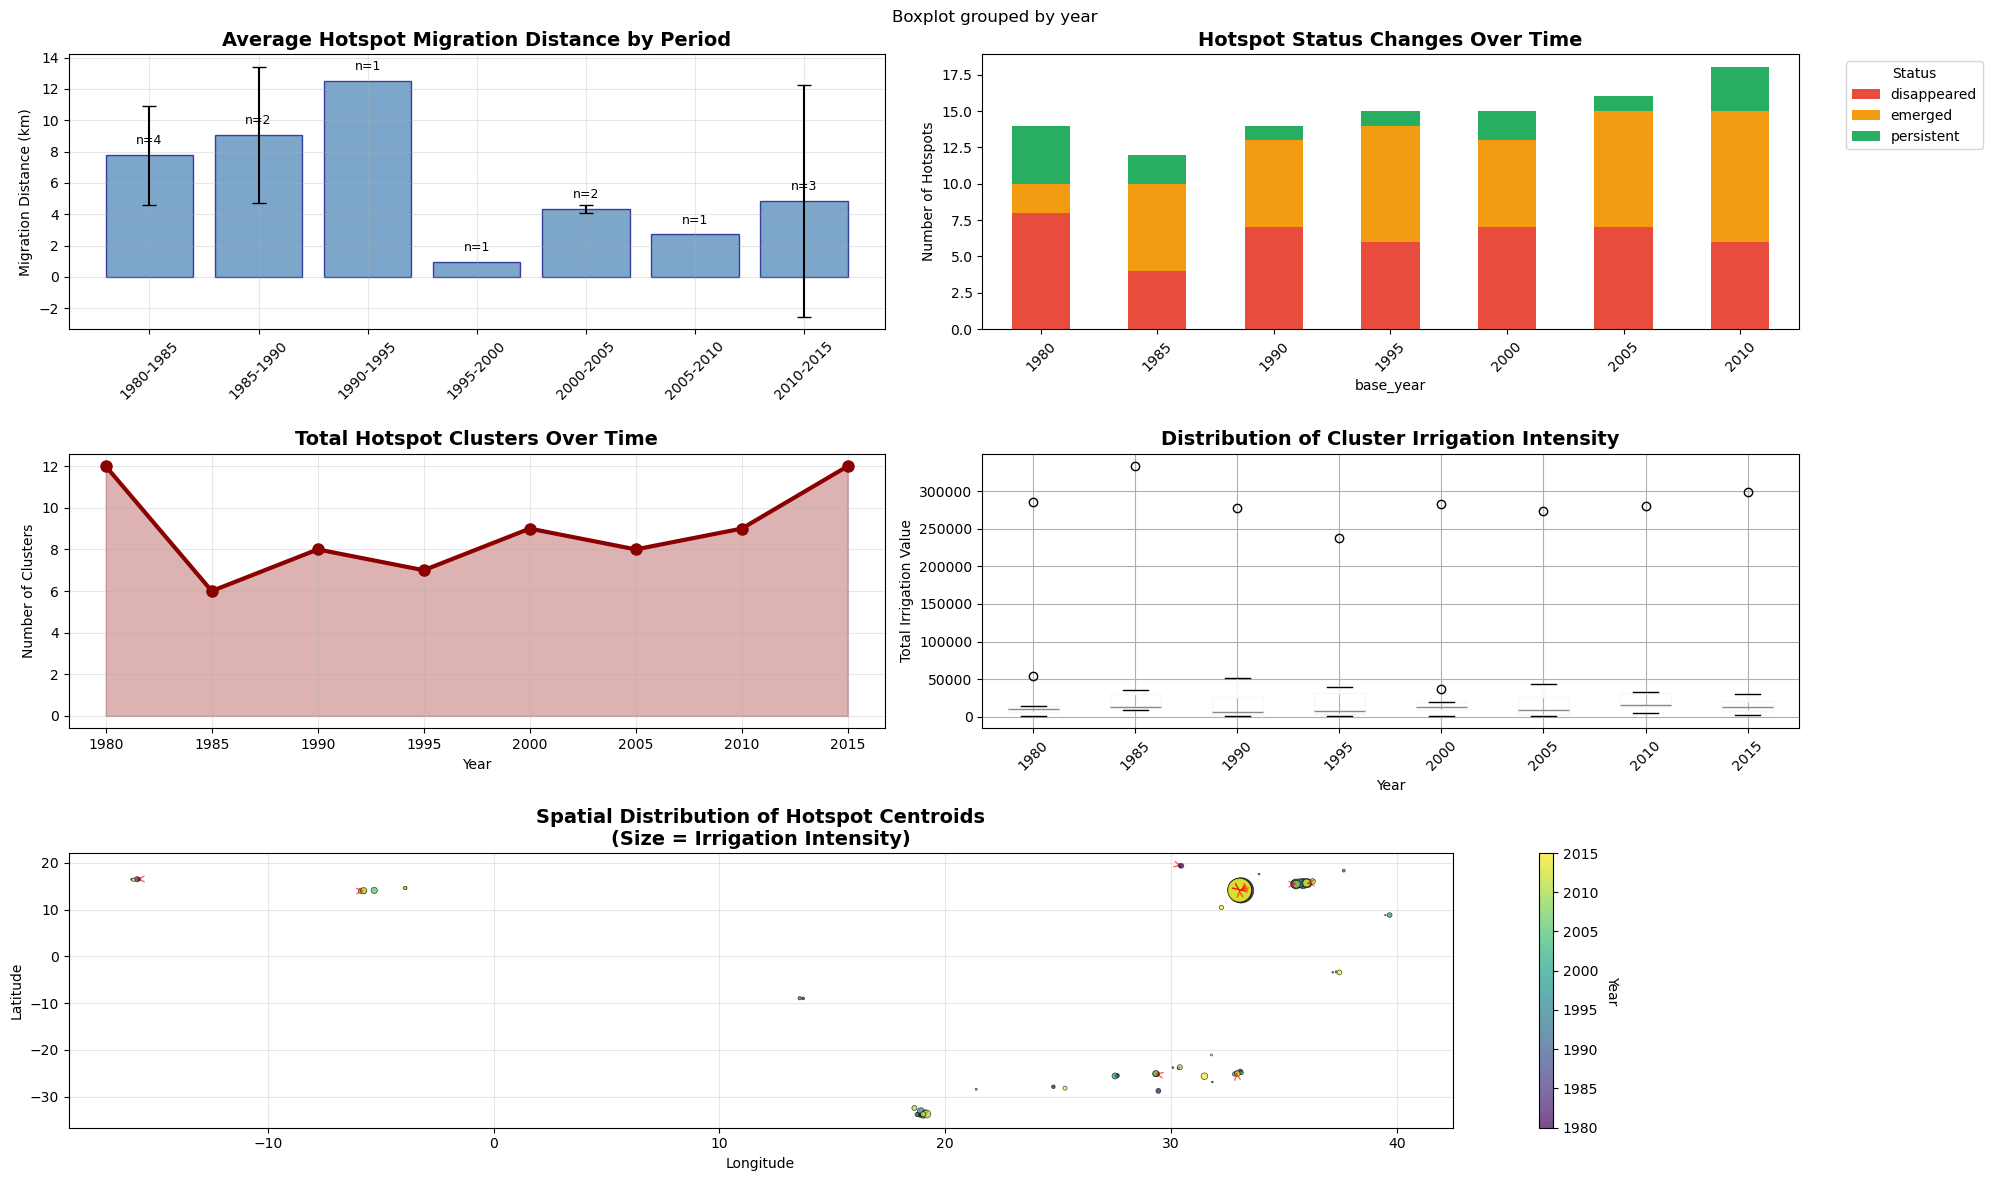

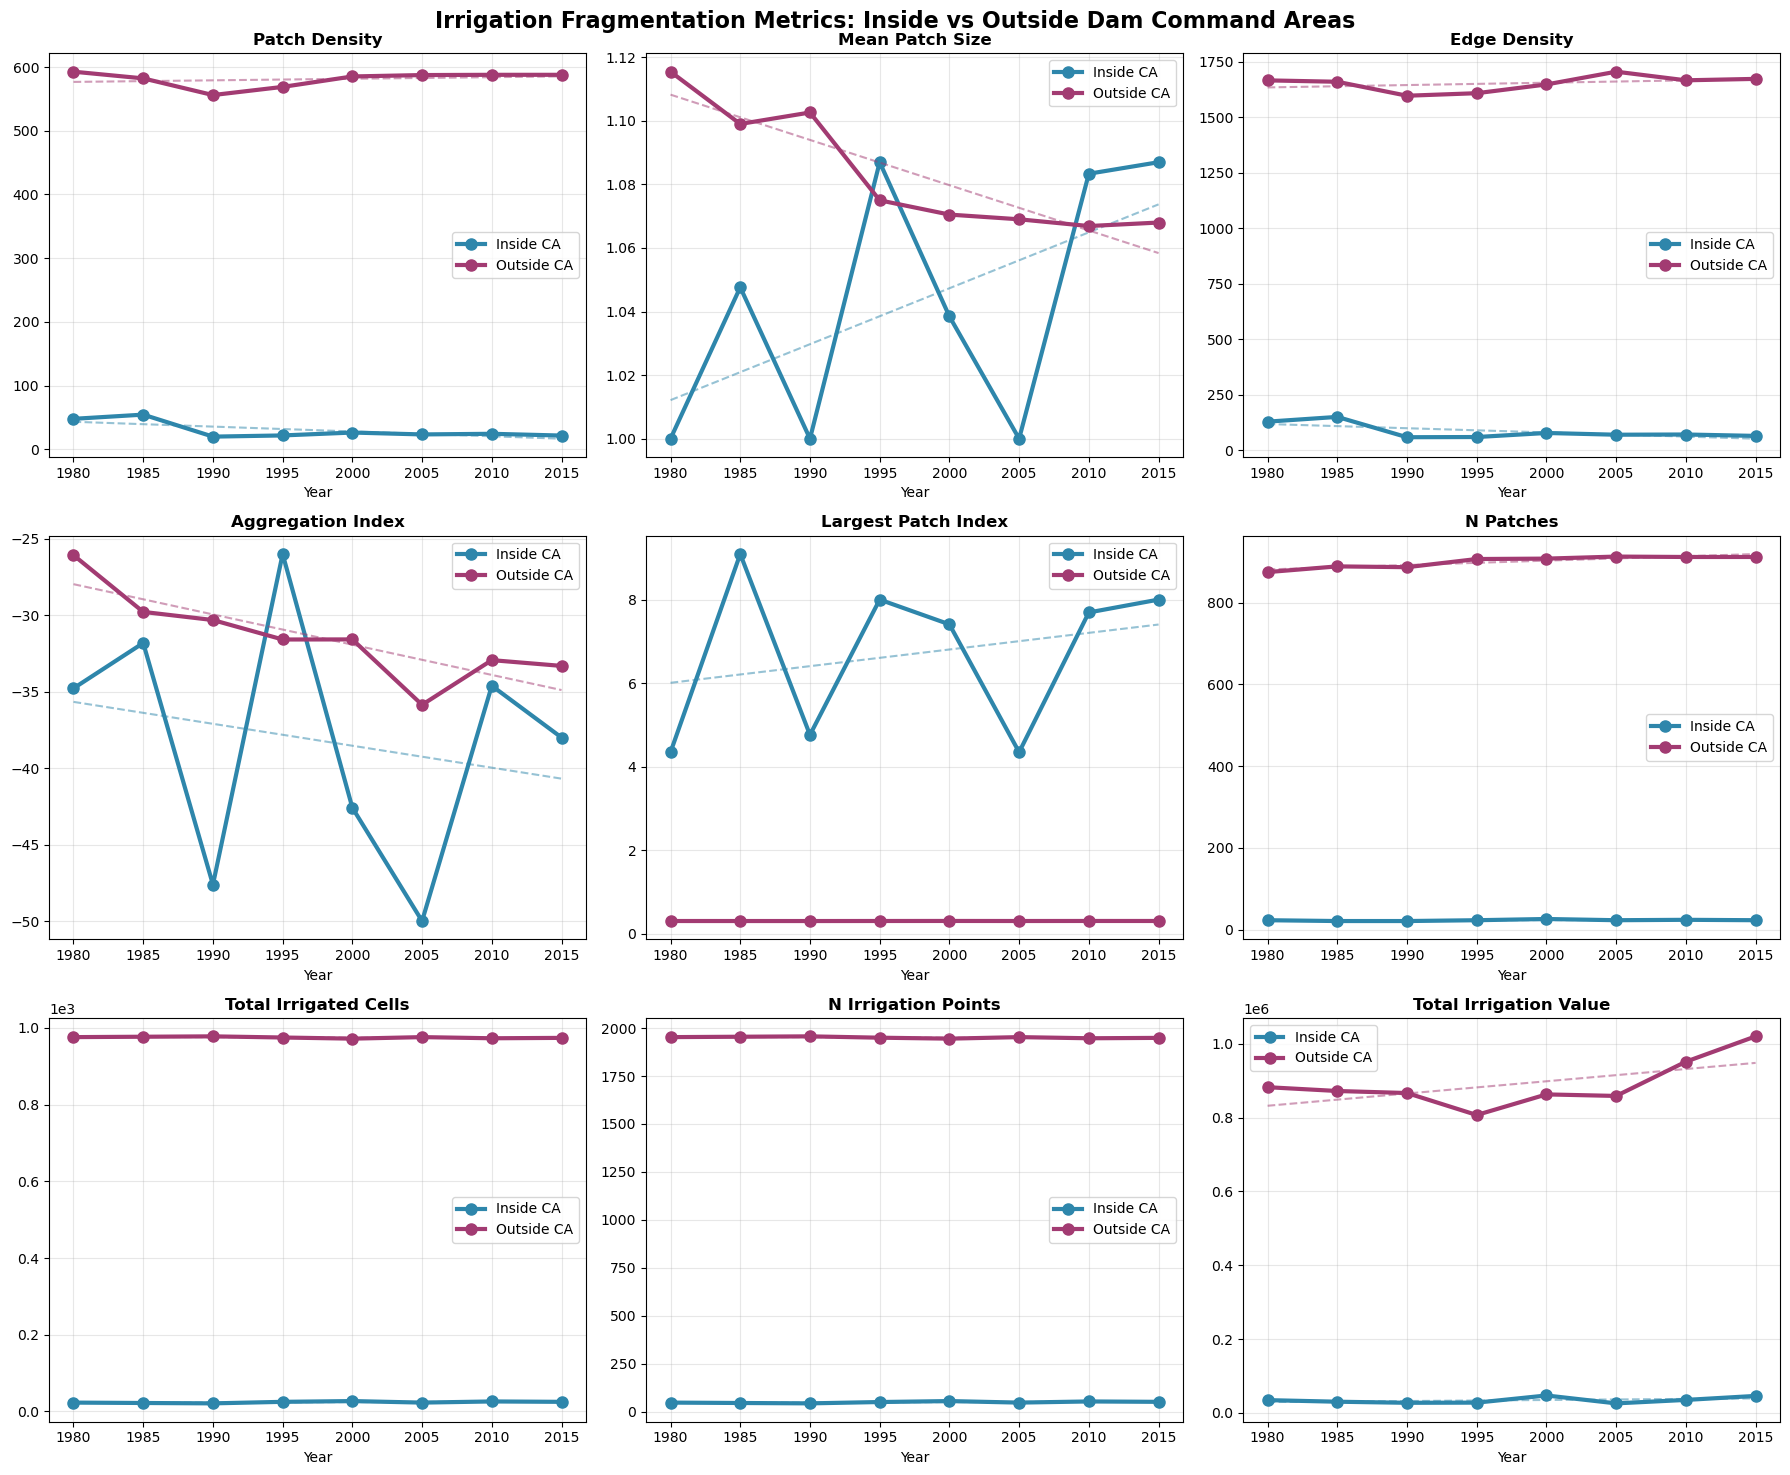

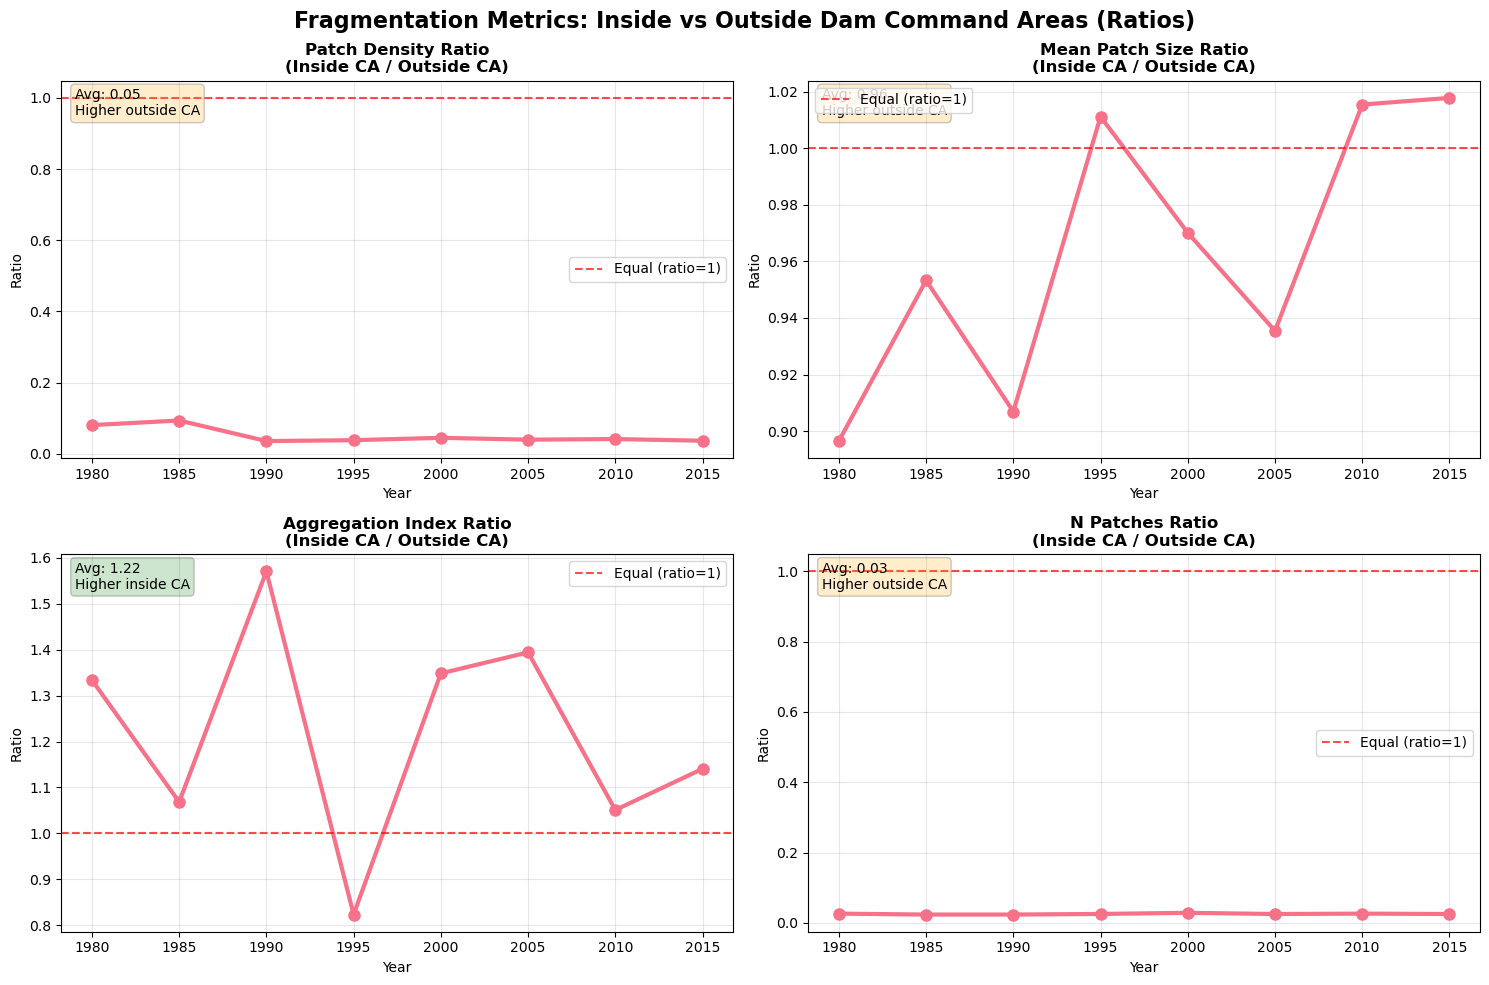

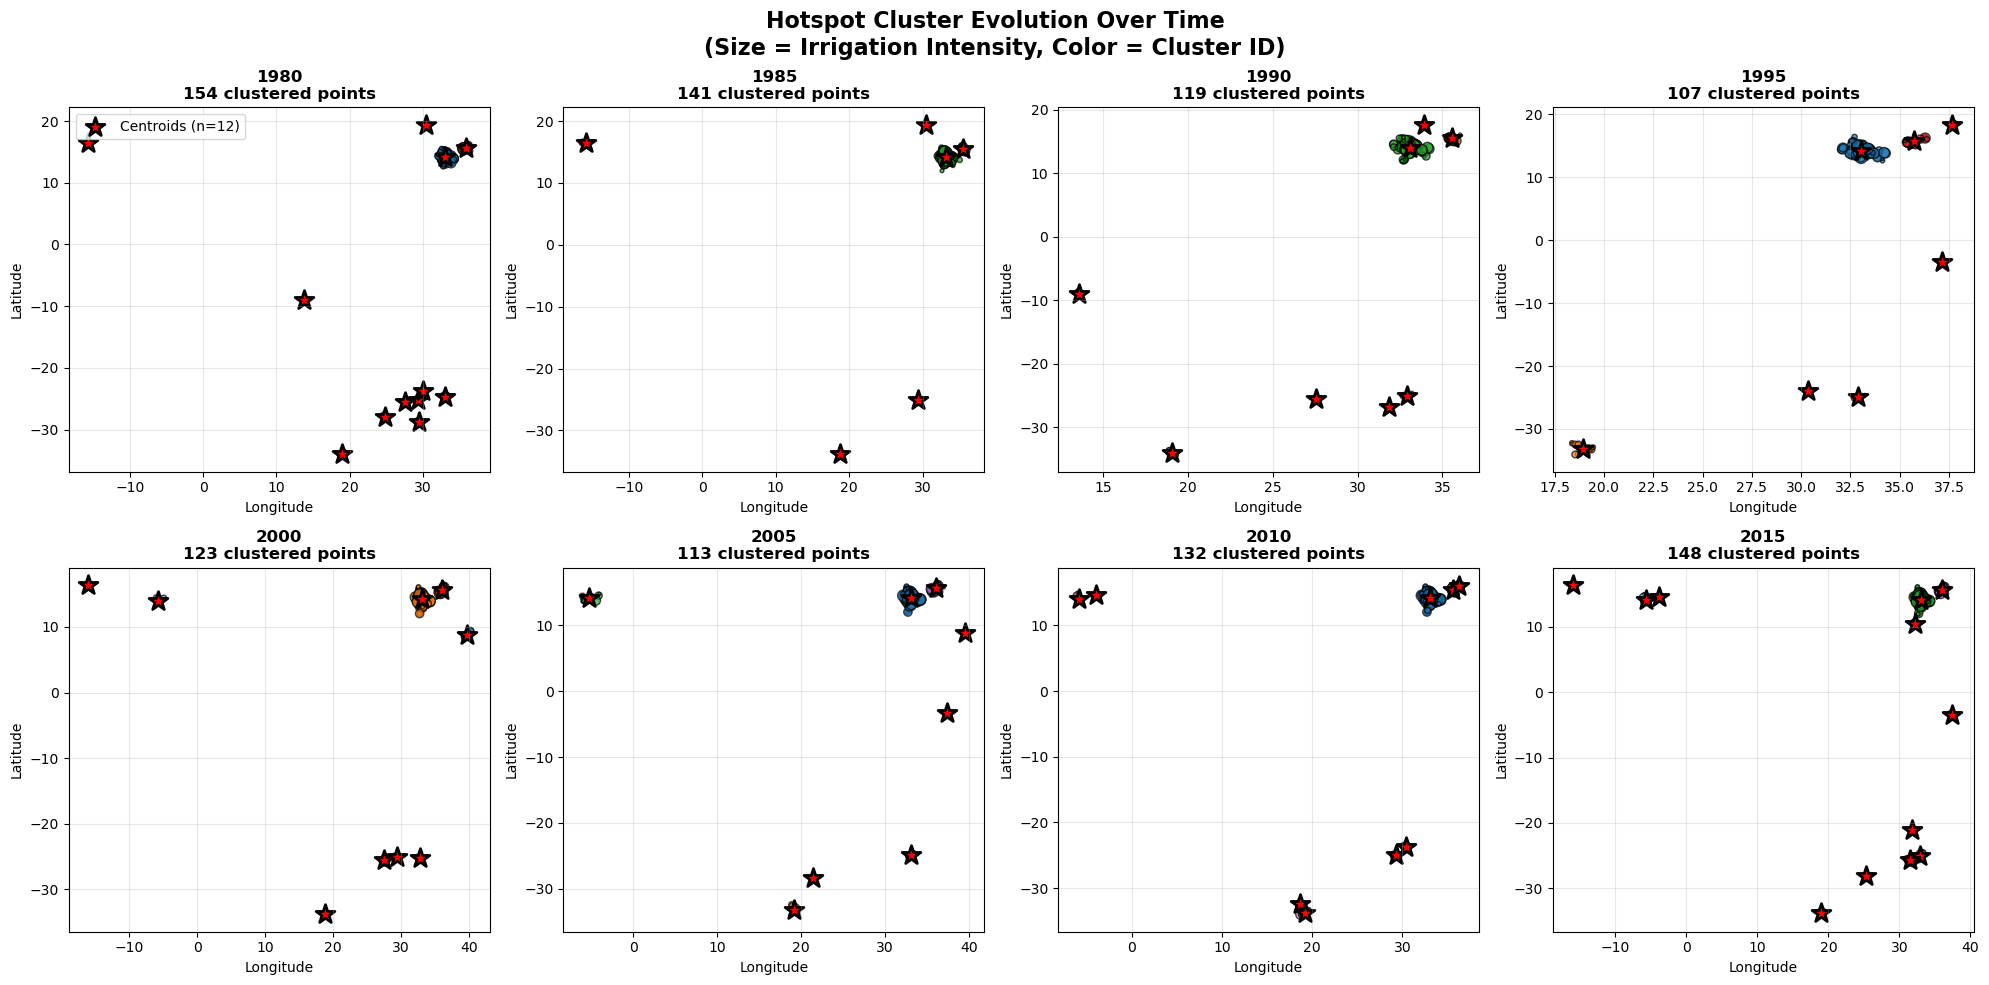

COMPREHENSIVE SPATIAL ANALYSIS SUMMARY

📍 HOTSPOT MIGRATION ANALYSIS
----------------------------------------
Total hotspot clusters identified: 71
Years analyzed: [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]
Persistent hotspots: 14
Emerged hotspots: 45
Disappeared hotspots: 45
Average migration distance: 6.33 km
Max migration distance: 13.35 km
Min migration distance: 0.00 km

🔄 FRAGMENTATION ANALYSIS
----------------------------------------
Average values across all years:
Metric                    Inside CA       Outside CA      Ratio (I/O)    
----------------------------------------------------------------------
Patch Density             29.81           581.00          0.05           
Mean Patch Size           1.04            1.08            0.96           
Aggregation Index         -38.18          -31.43          1.21           
Edge Density              84.80           1653.89         0.05           

📈 TREND ANALYSIS
----------------------------------------
Changes from 198

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

# Set style
plt.style.use('default')
sns.set_palette("husl")

def plot_hotspot_migration_comprehensive(persistence_df, all_centroids, years):
    """
    Comprehensive visualization of hotspot migration patterns
    """
    fig = plt.figure(figsize=(20, 12))
    
    # Create a complex grid layout
    gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 1])
    
    # 1. Migration distances over time
    ax1 = fig.add_subplot(gs[0, :2])
    persistent_data = persistence_df[persistence_df['status'] == 'persistent']
    if len(persistent_data) > 0:
        migration_by_period = persistent_data.groupby(['base_year', 'next_year']).agg({
            'migration_distance_km': ['mean', 'std', 'count']
        }).reset_index()
        migration_by_period.columns = ['base_year', 'next_year', 'mean_migration', 'std_migration', 'n_hotspots']
        migration_by_period['period'] = migration_by_period['base_year'].astype(str) + '-' + migration_by_period['next_year'].astype(str)
        
        bars = ax1.bar(migration_by_period['period'], migration_by_period['mean_migration'], 
                      yerr=migration_by_period['std_migration'], capsize=5, 
                      color='steelblue', alpha=0.7, edgecolor='navy')
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, migration_by_period['n_hotspots'])):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'n={int(count)}', ha='center', va='bottom', fontsize=9)
    
    ax1.set_title('Average Hotspot Migration Distance by Period', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Migration Distance (km)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Hotspot status changes over time
    ax2 = fig.add_subplot(gs[0, 2:])
    status_counts = persistence_df.groupby(['base_year', 'status']).size().unstack(fill_value=0)
    status_counts.plot(kind='bar', stacked=True, ax=ax2, 
                      color=['#e74c3c', '#f39c12', '#27ae60'])
    ax2.set_title('Hotspot Status Changes Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Hotspots')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Hotspot cluster count over time
    ax3 = fig.add_subplot(gs[1, :2])
    cluster_counts = all_centroids.groupby('year').size()
    ax3.plot(cluster_counts.index, cluster_counts.values, marker='o', linewidth=3, 
             markersize=8, color='darkred')
    ax3.fill_between(cluster_counts.index, cluster_counts.values, alpha=0.3, color='darkred')
    ax3.set_title('Total Hotspot Clusters Over Time', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Number of Clusters')
    ax3.grid(True, alpha=0.3)
    
    # 4. Irrigation intensity of clusters
    ax4 = fig.add_subplot(gs[1, 2:])
    if 'total_irrigation' in all_centroids.columns:
        all_centroids.boxplot(column='total_irrigation', by='year', ax=ax4)
        ax4.set_title('Distribution of Cluster Irrigation Intensity', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Year')
        ax4.set_ylabel('Total Irrigation Value')
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    # 5. Spatial distribution of centroids
    ax5 = fig.add_subplot(gs[2, :])
    if len(all_centroids) > 0:
        # Create a map showing centroid locations colored by year
        scatter = ax5.scatter(all_centroids['centroid_x'], all_centroids['centroid_y'], 
                             c=all_centroids['year'], cmap='viridis', 
                             s=all_centroids['total_irrigation']/1000, # Size by irrigation
                             alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax5)
        cbar.set_label('Year', rotation=270, labelpad=15)
        
        ax5.set_title('Spatial Distribution of Hotspot Centroids\n(Size = Irrigation Intensity)', 
                     fontsize=14, fontweight='bold')
        ax5.set_xlabel('Longitude')
        ax5.set_ylabel('Latitude')
        ax5.grid(True, alpha=0.3)
        
        # Add migration arrows for persistent hotspots
        if len(persistent_data) > 0:
            for _, row in persistent_data.iterrows():
                if not (pd.isna(row['base_x']) or pd.isna(row['next_x'])):
                    ax5.annotate('', xy=(row['next_x'], row['next_y']), 
                               xytext=(row['base_x'], row['base_y']),
                               arrowprops=dict(arrowstyle='->', color='red', alpha=0.6, lw=1))
    
    plt.tight_layout()
    plt.show()

def plot_fragmentation_comprehensive(fragmentation_df):
    """
    Comprehensive fragmentation analysis visualization
    """
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()
    
    metrics = ['patch_density', 'mean_patch_size', 'edge_density', 
               'aggregation_index', 'largest_patch_index', 'n_patches',
               'total_irrigated_cells', 'n_irrigation_points', 'total_irrigation_value']
    
    colors = {'inside': '#2E86AB', 'outside': '#A23B72'}
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        for zone in ['inside', 'outside']:
            zone_data = fragmentation_df[fragmentation_df['zone'] == zone]
            if len(zone_data) > 0:
                ax.plot(zone_data['year'], zone_data[metric], 
                       marker='o', label=f'{zone.title()} CA', linewidth=3, 
                       markersize=8, color=colors[zone])
                
                # Add trend line
                z = np.polyfit(zone_data['year'], zone_data[metric], 1)
                p = np.poly1d(z)
                ax.plot(zone_data['year'], p(zone_data['year']), 
                       linestyle='--', alpha=0.5, color=colors[zone])
        
        ax.set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
        ax.set_xlabel('Year')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format y-axis based on metric
        if metric in ['total_irrigation_value', 'total_irrigated_cells']:
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.suptitle('Irrigation Fragmentation Metrics: Inside vs Outside Dam Command Areas', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_fragmentation_ratios(fragmentation_df):
    """
    Plot ratios of inside/outside metrics to show relative differences
    """
    # Calculate ratios
    years = fragmentation_df['year'].unique()
    metrics = ['patch_density', 'mean_patch_size', 'aggregation_index', 'n_patches']
    
    ratio_data = []
    for year in years:
        year_data = fragmentation_df[fragmentation_df['year'] == year]
        inside_data = year_data[year_data['zone'] == 'inside']
        outside_data = year_data[year_data['zone'] == 'outside']
        
        if len(inside_data) > 0 and len(outside_data) > 0:
            inside = inside_data.iloc[0]
            outside = outside_data.iloc[0]
            
            for metric in metrics:
                if outside[metric] != 0:
                    ratio = inside[metric] / outside[metric]
                    ratio_data.append({
                        'year': year,
                        'metric': metric,
                        'ratio': ratio
                    })
    
    ratio_df = pd.DataFrame(ratio_data)
    
    if len(ratio_df) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            ax = axes[i]
            metric_data = ratio_df[ratio_df['metric'] == metric]
            
            if len(metric_data) > 0:
                ax.plot(metric_data['year'], metric_data['ratio'], 
                       marker='o', linewidth=3, markersize=8)
                ax.axhline(y=1, color='red', linestyle='--', alpha=0.7, 
                          label='Equal (ratio=1)')
                
                ax.set_title(f'{metric.replace("_", " ").title()} Ratio\n(Inside CA / Outside CA)', 
                           fontweight='bold')
                ax.set_xlabel('Year')
                ax.set_ylabel('Ratio')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Add interpretation text
                avg_ratio = metric_data['ratio'].mean()
                if avg_ratio > 1:
                    interpretation = "Higher inside CA"
                    color = 'green'
                elif avg_ratio < 1:
                    interpretation = "Higher outside CA"
                    color = 'orange'
                else:
                    interpretation = "Similar"
                    color = 'blue'
                
                ax.text(0.02, 0.98, f'Avg: {avg_ratio:.2f}\n{interpretation}', 
                       transform=ax.transAxes, fontsize=10, 
                       bbox=dict(boxstyle='round', facecolor=color, alpha=0.2),
                       verticalalignment='top')
        
        plt.suptitle('Fragmentation Metrics: Inside vs Outside Dam Command Areas (Ratios)', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

def create_summary_statistics_table(persistence_df, fragmentation_df, all_centroids):
    """
    Create a comprehensive summary statistics table
    """
    print("="*80)
    print("COMPREHENSIVE SPATIAL ANALYSIS SUMMARY")
    print("="*80)
    
    # Hotspot Analysis Summary
    print("\n📍 HOTSPOT MIGRATION ANALYSIS")
    print("-" * 40)
    print(f"Total hotspot clusters identified: {len(all_centroids)}")
    print(f"Years analyzed: {sorted(all_centroids['year'].unique()) if len(all_centroids) > 0 else 'None'}")
    
    if len(persistence_df) > 0:
        status_counts = persistence_df['status'].value_counts()
        print(f"Persistent hotspots: {status_counts.get('persistent', 0)}")
        print(f"Emerged hotspots: {status_counts.get('emerged', 0)}")
        print(f"Disappeared hotspots: {status_counts.get('disappeared', 0)}")
        
        persistent_hotspots = persistence_df[persistence_df['status'] == 'persistent']
        if len(persistent_hotspots) > 0:
            print(f"Average migration distance: {persistent_hotspots['migration_distance_km'].mean():.2f} km")
            print(f"Max migration distance: {persistent_hotspots['migration_distance_km'].max():.2f} km")
            print(f"Min migration distance: {persistent_hotspots['migration_distance_km'].min():.2f} km")
    
    # Fragmentation Analysis Summary
    print("\n🔄 FRAGMENTATION ANALYSIS")
    print("-" * 40)
    
    # Select only numeric columns for averaging
    numeric_cols = fragmentation_df.select_dtypes(include=[np.number]).columns

    # Average values by zone
    inside_avg = fragmentation_df[fragmentation_df['zone'] == 'inside'][numeric_cols].mean()
    outside_avg = fragmentation_df[fragmentation_df['zone'] == 'outside'][numeric_cols].mean()
    
    print("Average values across all years:")
    print(f"{'Metric':<25} {'Inside CA':<15} {'Outside CA':<15} {'Ratio (I/O)':<15}")
    print("-" * 70)
    
    metrics = ['patch_density', 'mean_patch_size', 'aggregation_index', 'edge_density']
    for metric in metrics:
        inside_val = inside_avg[metric]
        outside_val = outside_avg[metric]
        ratio = inside_val / outside_val if outside_val != 0 else np.nan
        print(f"{metric.replace('_', ' ').title():<25} {inside_val:<15.2f} {outside_val:<15.2f} {ratio:<15.2f}")
    
    # Trend analysis
    print("\n📈 TREND ANALYSIS")
    print("-" * 40)
    
    years = sorted(fragmentation_df['year'].unique())
    first_year = years[0]
    last_year = years[-1]
    
    first_year_data = fragmentation_df[fragmentation_df['year'] == first_year]
    last_year_data = fragmentation_df[fragmentation_df['year'] == last_year]
    
    print(f"Changes from {first_year} to {last_year}:")
    
    for zone in ['inside', 'outside']:
        print(f"\n{zone.title()} Command Areas:")
        first_zone = first_year_data[first_year_data['zone'] == zone].iloc[0]
        last_zone = last_year_data[last_year_data['zone'] == zone].iloc[0]
        
        for metric in ['patch_density', 'aggregation_index', 'n_irrigation_points']:
            change = last_zone[metric] - first_zone[metric]
            pct_change = (change / first_zone[metric] * 100) if first_zone[metric] != 0 else 0
            print(f"  {metric.replace('_', ' ').title()}: {change:+.2f} ({pct_change:+.1f}%)")

def plot_cluster_evolution_map(yearly_clusters, all_centroids, years):
    """
    Create an animated-style map showing cluster evolution
    """
    # Create subplots for each year
    n_years = len(years)
    cols = 4
    rows = (n_years + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Hide extra subplots
    for i in range(n_years, len(axes)):
        axes[i].set_visible(False)
    
    for i, year in enumerate(years):
        ax = axes[i]
        
        if year in yearly_clusters and len(yearly_clusters[year]) > 0:
            clusters = yearly_clusters[year]
            
            # Plot all points
            ax.scatter(clusters.geometry.x, clusters.geometry.y, 
                      c=clusters['cluster_id'], cmap='tab10', 
                      s=clusters['value']/100, alpha=0.7, edgecolors='black')
            
            # Plot centroids
            year_centroids = all_centroids[all_centroids['year'] == year]
            if len(year_centroids) > 0:
                ax.scatter(year_centroids['centroid_x'], year_centroids['centroid_y'], 
                          c='red', s=200, marker='*', edgecolors='black', linewidth=2,
                          label=f'Centroids (n={len(year_centroids)})')
        
        ax.set_title(f'{year}\n{len(yearly_clusters.get(year, []))} clustered points', 
                    fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, alpha=0.3)
        
        if i == 0:  # Add legend to first subplot
            ax.legend()
    
    plt.suptitle('Hotspot Cluster Evolution Over Time\n(Size = Irrigation Intensity, Color = Cluster ID)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage example:
def run_comprehensive_visualization(yearly_clusters, all_centroids, persistence_df, fragmentation_df, years):
    """
    Run all visualization functions
    """
    print("Creating comprehensive visualizations...")
    
    # 1. Hotspot migration analysis
    plot_hotspot_migration_comprehensive(persistence_df, all_centroids, years)
    
    # 2. Fragmentation analysis
    plot_fragmentation_comprehensive(fragmentation_df)
    
    # 3. Fragmentation ratios
    plot_fragmentation_ratios(fragmentation_df)
    
    # 4. Cluster evolution map
    plot_cluster_evolution_map(yearly_clusters, all_centroids, years)
    
    # 5. Summary statistics
    create_summary_statistics_table(persistence_df, fragmentation_df, all_centroids)
    
    print("All visualizations complete!")

# To use:
run_comprehensive_visualization(yearly_clusters, all_centroids, persistence_df, fragmentation_df, years)